# 🧠 Emotion Detection from Text Files (.txt)
This notebook reads emotion-labeled text files, trains a text classification model, and prepares it for Streamlit UI.

In [1]:
%pip install pandas numpy scikit-learn nltk joblib matplotlib seaborn

  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp312-cp312-win_amd64.whl.metadata (108 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ---------------------------------------- 0/7 [pyparsing]
   -----------------

In [2]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import pandas as pd

def load_semicolon_labeled_file(file_path):
    texts = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if ";" in line:
                text, label = line.strip().rsplit(";", 1)
                texts.append(text.strip())
                labels.append(label.strip())
    return pd.DataFrame({"text": texts, "label": labels})

# Example usage:
train_df = load_semicolon_labeled_file(r"C:\Users\satya\Downloads\archive (7)\train.txt")
val_df = load_semicolon_labeled_file(r"C:\Users\satya\Downloads\archive (7)\val.txt")
test_df = load_semicolon_labeled_file(r"C:\Users\satya\Downloads\archive (7)\test.txt")

train_df.head()


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return " ".join([word for word in text.split() if word not in stop_words])

train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_val = vectorizer.transform(val_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

In [9]:
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)

# Evaluate on validation set
val_pred = model.predict(X_val)
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

       anger       0.90      0.84      0.87       275
        fear       0.85      0.77      0.81       212
         joy       0.87      0.95      0.91       704
        love       0.89      0.73      0.80       178
     sadness       0.88      0.94      0.91       550
    surprise       0.86      0.62      0.72        81

    accuracy                           0.88      2000
   macro avg       0.88      0.81      0.84      2000
weighted avg       0.88      0.88      0.88      2000



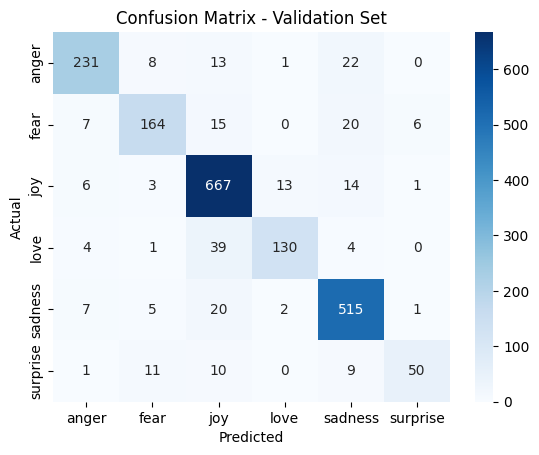

In [10]:
cm = confusion_matrix(y_val, val_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap="Blues")
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
joblib.dump(model, "emotion_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("✅ Model and vectorizer saved!")

✅ Model and vectorizer saved!


## 🚀 Streamlit UI (Save as `app.py` in same folder)

```python
import streamlit as st
import joblib
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

model = joblib.load("emotion_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return " ".join([word for word in text.split() if word not in stop_words])

st.set_page_config(page_title="Emotion Detector", layout="centered")
st.title("🧠 Emotion Detection from Text Files")
st.write("Enter any message to detect the **emotion** behind it.")

user_input = st.text_area("💬 Your Message", placeholder="e.g., I feel amazing today!", height=150)

if st.button("🔍 Detect Emotion"):
    if user_input.strip() == "":
        st.warning("Please enter some text.")
    else:
        cleaned = clean_text(user_input)
        vec = vectorizer.transform([cleaned])
        pred = model.predict(vec)[0]
        st.success(f"🎭 **Predicted Emotion:** {pred}")
```

➡️ After training, run the app using:
```bash
streamlit run app.py
```